<p style="padding: 10px;color: Green;font-weight: bold;
          text-align: center; font-size:250%;">Store Item Demand Forecasting</p>


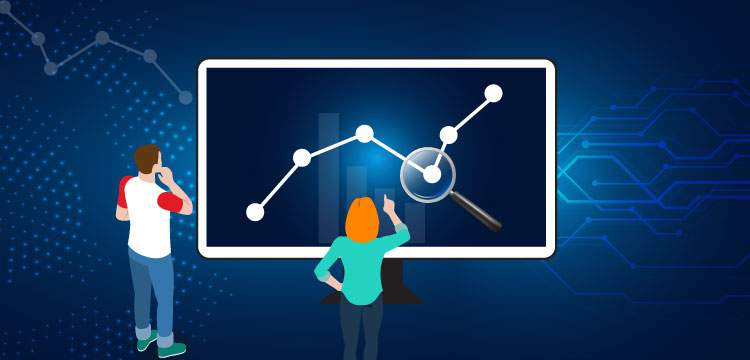

<a id = "1"></a><h1 id="Introduction"><span class="label label-default" style="font-size:30px; color: Black; ">Introduction</span></h1>

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

<a id = "2"></a><h1 id="Importing Libraries and Utilities"><span class="label label-default" style="font-size:30px; color: Black; ">Importing Libraries and Utilities</span></h1>

In [ ]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate,\
    validation_curve, train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

<a id = "3"></a><h1 id="Load and Check Data"><span class="label label-default" style="font-size:30px; color: Black; ">Load and Check Data</span></h1>

In [ ]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False)

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(train)

In [ ]:
check_df(test)

In [ ]:
df[["sales"]].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]).T

In [ ]:
# How many unique stores are there?
df["store"].nunique()

In [ ]:
df["sales"].sort_values(ascending=False).head()

In [ ]:
# Are there an equal number of unique items in each store?
df.groupby(["store"])["item"].nunique()

In [ ]:
# Sales statistics in store breakdown
df.groupby("store").agg({"sales": ["sum", "mean", "median", "std"]})

In [ ]:
# 2D graphic to see seasonality
sns.lineplot(x="date",y="sales", legend="full",data=train)
plt.show()

<a id = "4"></a><h1 id="Feature Engineering"><span class="label label-default" style="font-size:30px; color: Black; ">Feature Engineering</span></h1>

In [ ]:
# Date Features
def create_date_features(dataframe):
    dataframe['month'] = dataframe.date.dt.month
    dataframe['day_of_month'] = dataframe.date.dt.day
    dataframe['day_of_year'] = dataframe.date.dt.dayofyear
    dataframe['week_of_year'] = dataframe.date.dt.weekofyear
    dataframe['day_of_week'] = dataframe.date.dt.dayofweek
    dataframe['year'] = dataframe.date.dt.year
    dataframe["is_wknd"] = dataframe.date.dt.weekday // 4
    dataframe['is_month_start'] = dataframe.date.dt.is_month_start.astype(int)
    dataframe['is_month_end'] = dataframe.date.dt.is_month_end.astype(int)
    return df
df = create_date_features(df)

check_df(df)

In [ ]:
# Sales statistics in store-item-month 
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

## Random Noise

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

a = np.random.normal(scale=1.6, size=(len(df)))

sns.distplot(a)
plt.show()

## Lag/Shifted Features

In [ ]:
# The feature order here is important, first we set it as store, item, date.
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df.tail()

## Rolling Mean Features 

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])
df.tail()

## Exponentially Weighted Mean Features

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

df.tail()

## One-Hot Encoding

In [ ]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

<a id = "5"></a><h1 id="LightGBM Model"><span class="label label-default" style="font-size:30px; color: Black; ">LightGBM Model</span></h1>

In [ ]:
# Converting sales to log(1+sales)
df['sales'] = np.log1p(df["sales"].values)
df.head()

## Custom Cost Function

In [ ]:
# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

## Time-Based Validation Sets

In [ ]:
# Train set until the beginning of 2017 (until the end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]

# First three months of 2017 validation set.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

# Selecting the dependent and independent variable for the train set
Y_train = train['sales']
X_train = train[cols]

# Choosing the dependent and independent variable for the validation set
Y_val = val['sales']
X_val = val[cols]

In [ ]:
Y_train.shape, Y_train.shape, Y_val.shape, X_val.shape

##  LightGBM Parameters

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [ ]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

<a id = "6"></a><h1 id="Feature Importancel"><span class="label label-default" style="font-size:30px; color: Black; ">Feature Importance</span></h1>

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30, plot=True)
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

<a id = "7"></a><h1 id="Final Model"><span class="label label-default" style="font-size:30px; color: Black; ">Final Model</span></h1>

In [ ]:

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}


# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

test_preds = model.predict(X_test, num_iteration=model.best_iteration)

<a id = "8"></a><h1 id="Submission"><span class="label label-default" style="font-size:30px; color: Black; ">Submission</span></h1>

In [ ]:
submission_df = test.loc[:, ['id', 'sales']]

# Undoing the standardization process.
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission_demand.csv', index=False)
submission_df.head(10)

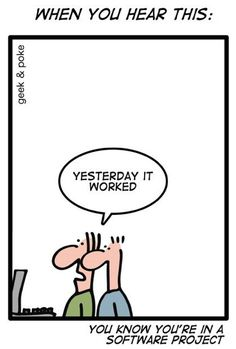